# C3S Atlas notebooks

***

>This notebook reproduces and extends parts of the figures and products provided by the Copernicus Interactive Climate Atlas (C3S Atlas, [https://atlas.climate.copernicus.eu/atlas](https://atlas.climate.copernicus.eu/atlas)). It is part of a notebook library produced for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0) and has been produced by IFCA-CSIC and Predictia for the C3S.
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Time Series

This Jupyter Notebook reproduces the Time Series product from the C3S Atlas.

The time-series product (for **observations**) displays the regionally aggregated annual/seasonal series. A gray shading indicates the selected period, as represented in the map. 
The time-series product (for **model simulations**) displays the regionally aggregated annual/seasonal series for the raw values or the changes (anomalies relative to the selected baseline in this case) for all the simulations forming the ensemble, as well as the ensemble median. A gray shading indicates the particular period selected, as represented in the map; in the case of global warming levels, the shading area exhibits different intensities according to the overlaps of 20-year periods where the warming level is first reached by the different models (higher intensity indicates years with higher overlap).


### Load Python packages and clone and install the **user-tools** repository from the C3S Atlas GitLab repository

Clone (`git clone`) the [C3S-Atlas-user-tools](https://gitlab.predictia.es/c3s-cica/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the requirements section of the README: https://gitlab.predictia.es/c3s-cica/c3s-atlas#requirements

In [2]:
import os
import xarray as xr
import glob
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi

from c3s_atlas.software.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.software.customized_regions import (
    Mask
)
from c3s_atlas.software.analysis import (
    monthly_weighted_average, 
)
from c3s_atlas.software.products import (
    time_series,
)
from c3s_atlas.software.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_selected_data
)

### Dowload climate data with the CDS API
- Catalog: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

- [How to use the CDS API](https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [3]:
project = "CMIP6"
scenario = "ssp370"
var = 'pr'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'pr_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'historical',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'pr_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp3_7_0',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios might have different number of members

In [8]:
ds_hist = xr.open_dataset(dest / "pr_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "pr_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define season

In [9]:
season = [3, 4, 5] # Months

In [10]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

#### Select Region

In [11]:
mask = Mask(ds).regions_AR6(['MED'])
filtered_ds = ds.where(mask)

### Analysis for the product

In [12]:
time_series_ds = monthly_weighted_average(filtered_ds, var, season)

### Plot

#### a) Climatology

In [13]:
mode = 'climatology'
period = slice(2081, 2100)

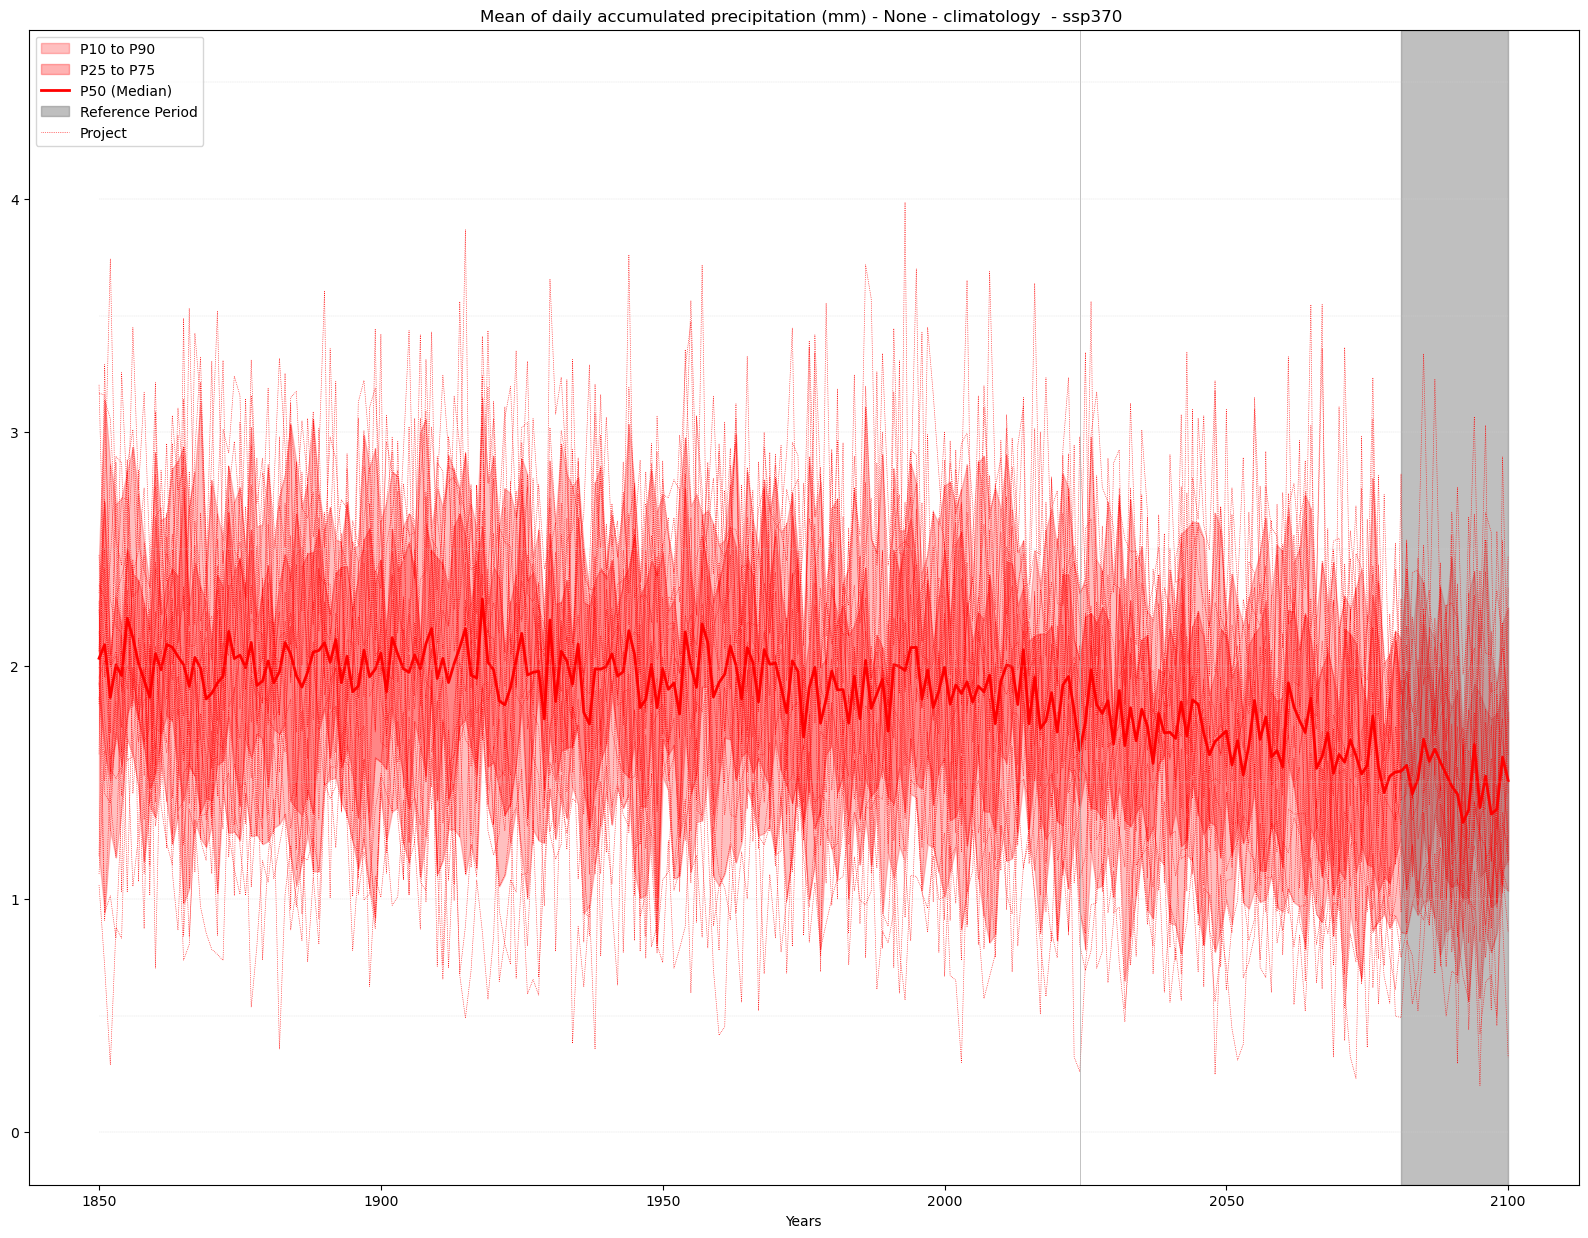

In [14]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, season = season, period = period)

#### b) Absolute change

In [15]:
mode = 'change'
diff = 'abs'
period = slice(2081,2100)
baseline_period = slice(1981,2010)

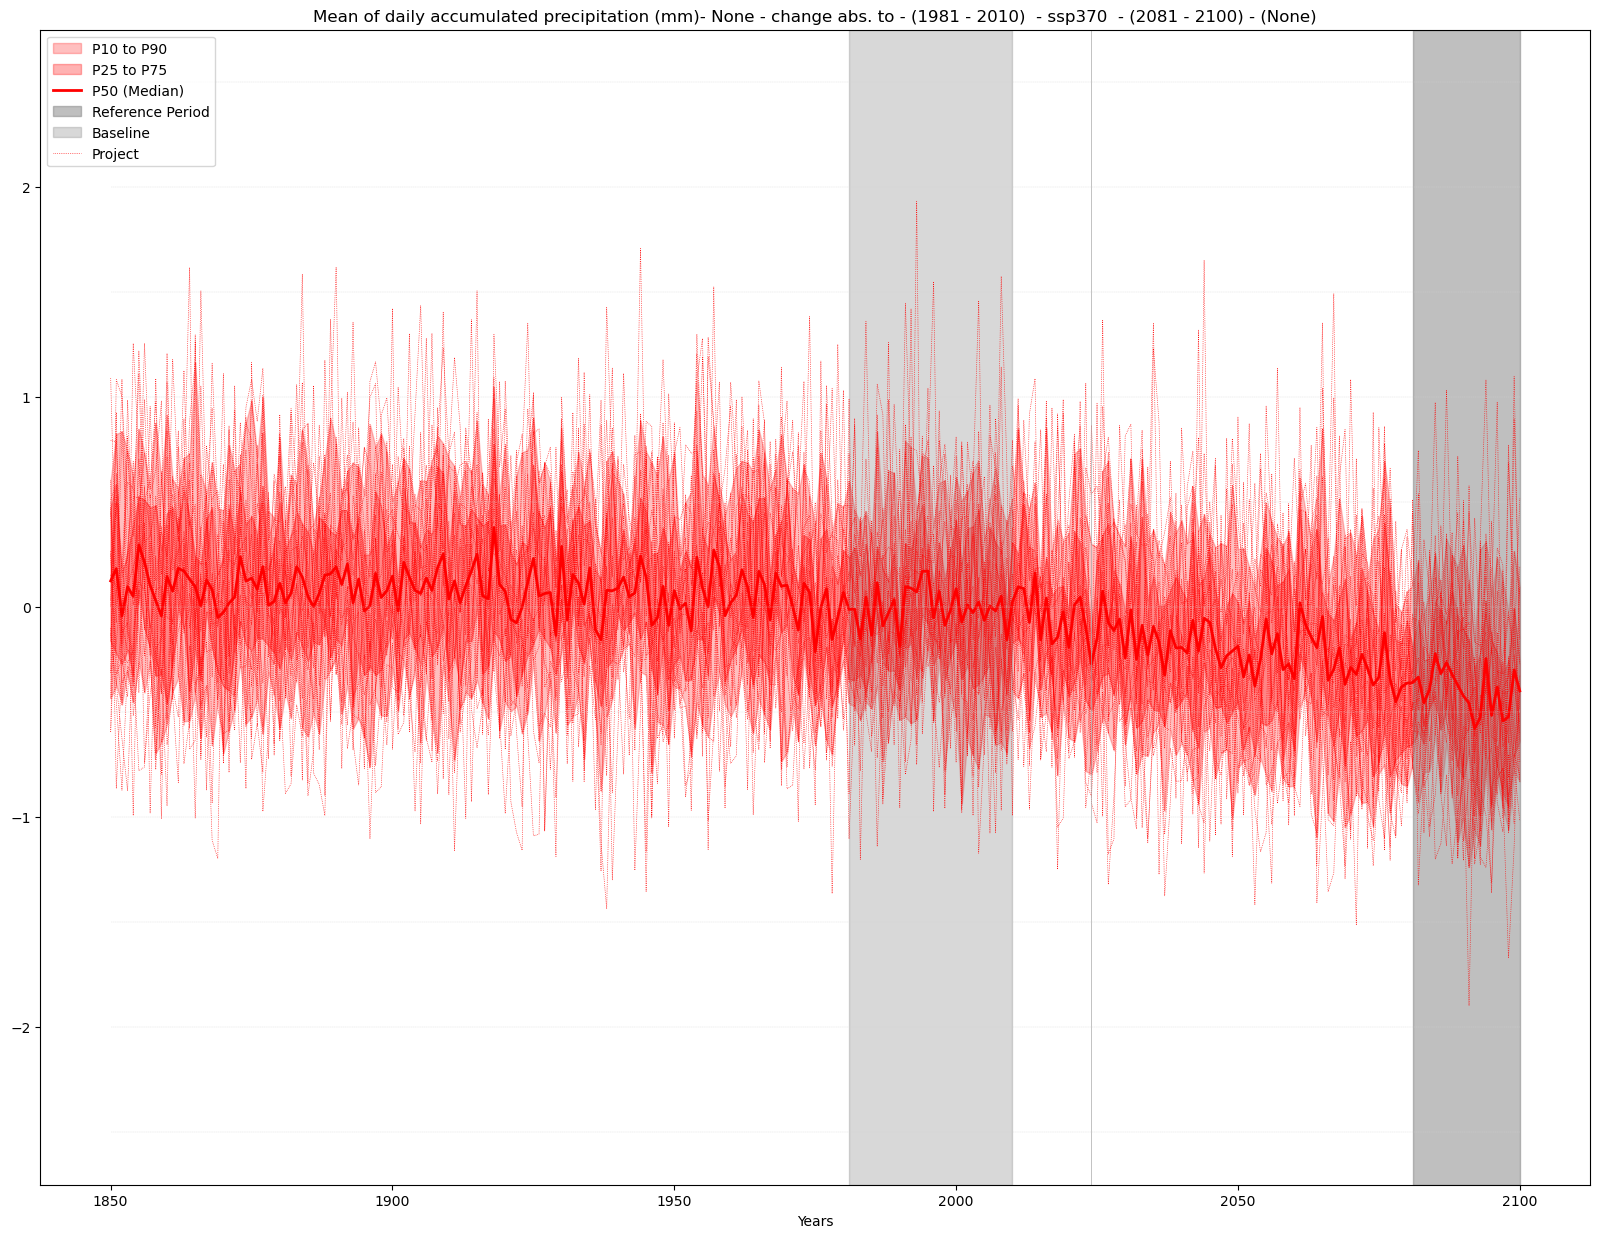

In [16]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, diff = diff, season = season,
                               baseline_period = baseline_period, period = period)

#### c) Relative change

In [17]:
mode = 'change'
diff = 'rel'
period = slice(2081,2100)
baseline_period = slice(1981,2010)

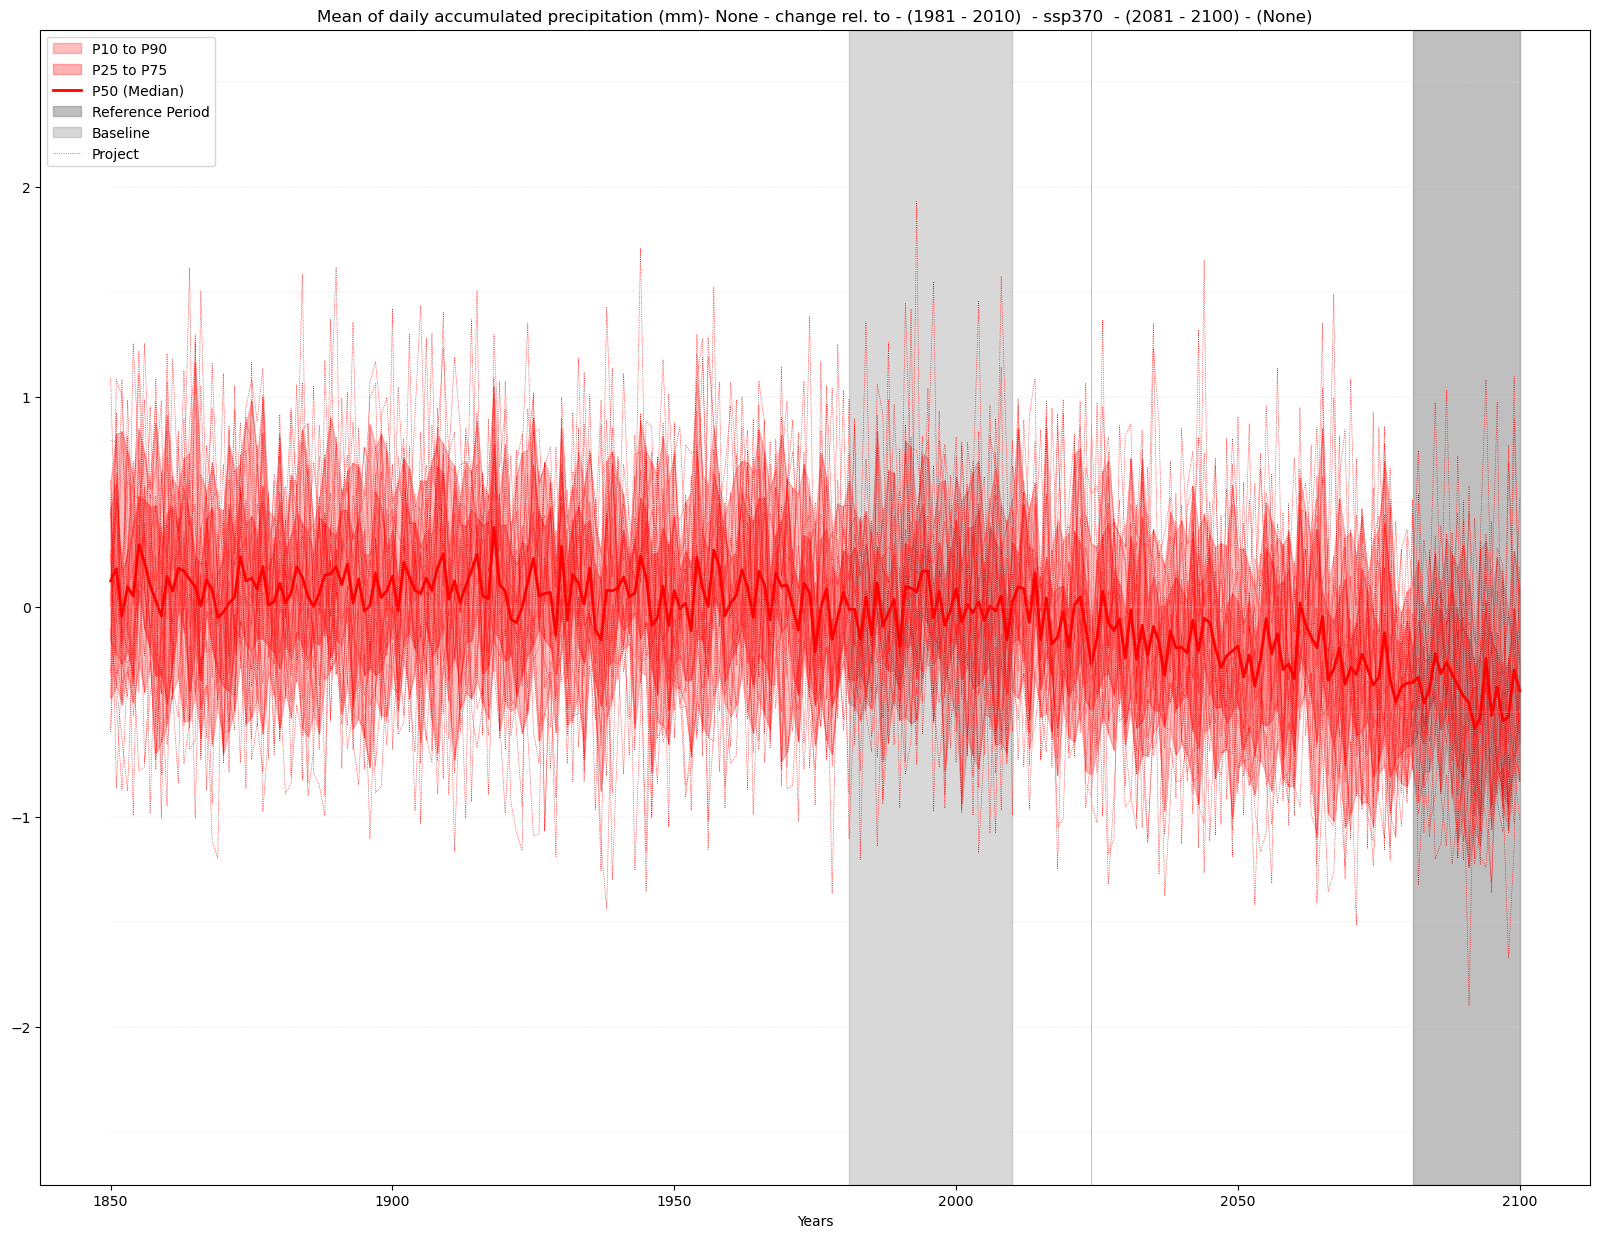

In [18]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, diff = diff, season = season,
                               baseline_period = baseline_period, period = period)

## Globar Warning Levels

In [19]:
#Load the data and get the intersection of the members
GWL= '4'
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)

In [20]:
 filtered_GWLs_ds = get_selected_data(filtered_ds, GWLs_members_with_period)

### Analysis

In [21]:
time_series_GWL_ds = annual_weighted_average(filtered_GWLs_ds, var, season)

### Plot

In [22]:
mode = 'climatology'
baseline_period = slice(1981,2010)

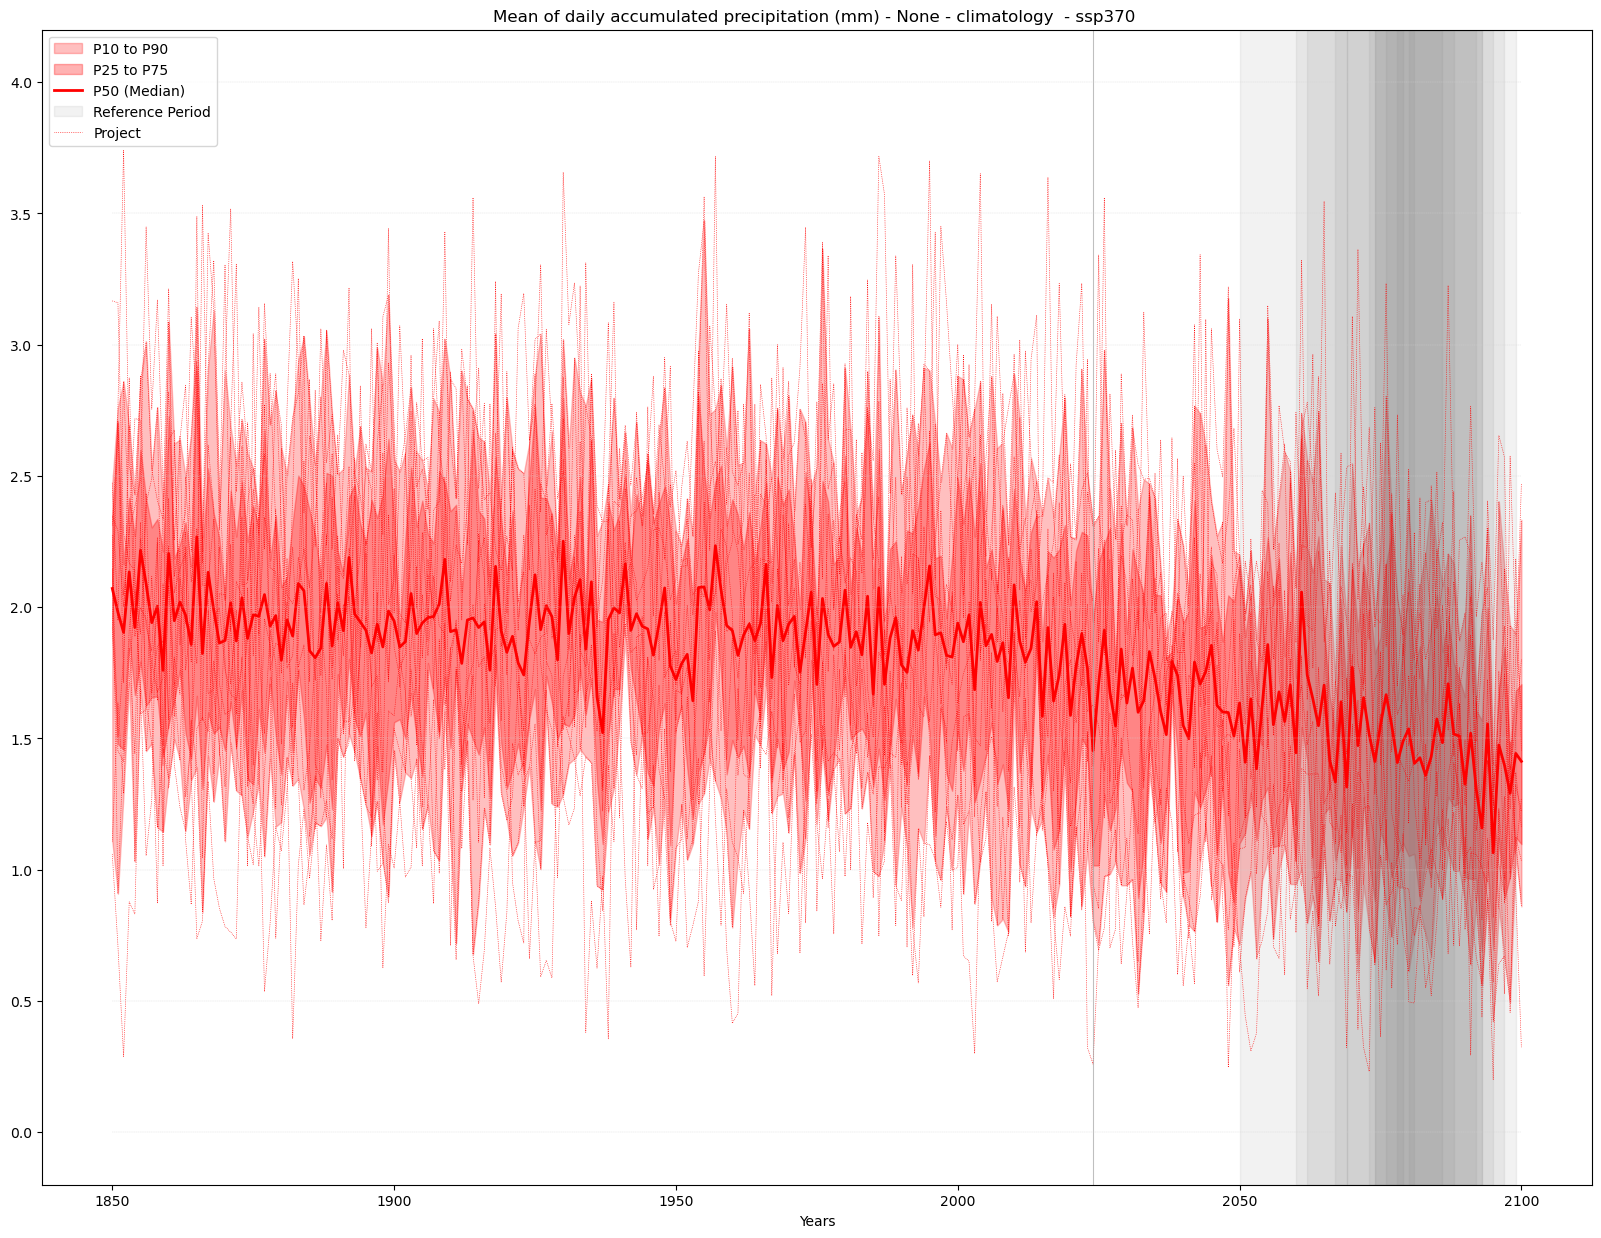

In [23]:
time_series_plot = time_series(time_series_GWL_ds, var, attrs, 
                               mode = mode, season = season, 
                               baseline_period = baseline_period,
                               GWL = GWLs_members_with_period, GWLs = GWL)

## Trends

#### Download data from the "Copernicus Interactive Climate Atlas: gridded monthly dataset"

In [25]:
project = "ERA5"
var = 'pr'
season = [3, 4, 5] # Months

In [26]:
dest = Path('./data/ERA5')
os.makedirs(dest, exist_ok=True)

In [ ]:
filename = 'pr_ERA5_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'era5',
    'domain': 'global',
    'period': '1940-2022',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [38]:
ds = xr.open_dataset(dest / "pr_ERA5_mon_194001-202212.nc")

In [39]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

### Analysis

In [40]:
trend_period=slice('1991','2020')

In [41]:
mask = Mask(ds).regions_AR6(['MED'])
filtered_ds = ds.where(mask)

In [42]:
time_series_ds, results = mean_year(filtered_ds, var, season, trend = True, 
                                    trend_period=trend_period)

### Plot

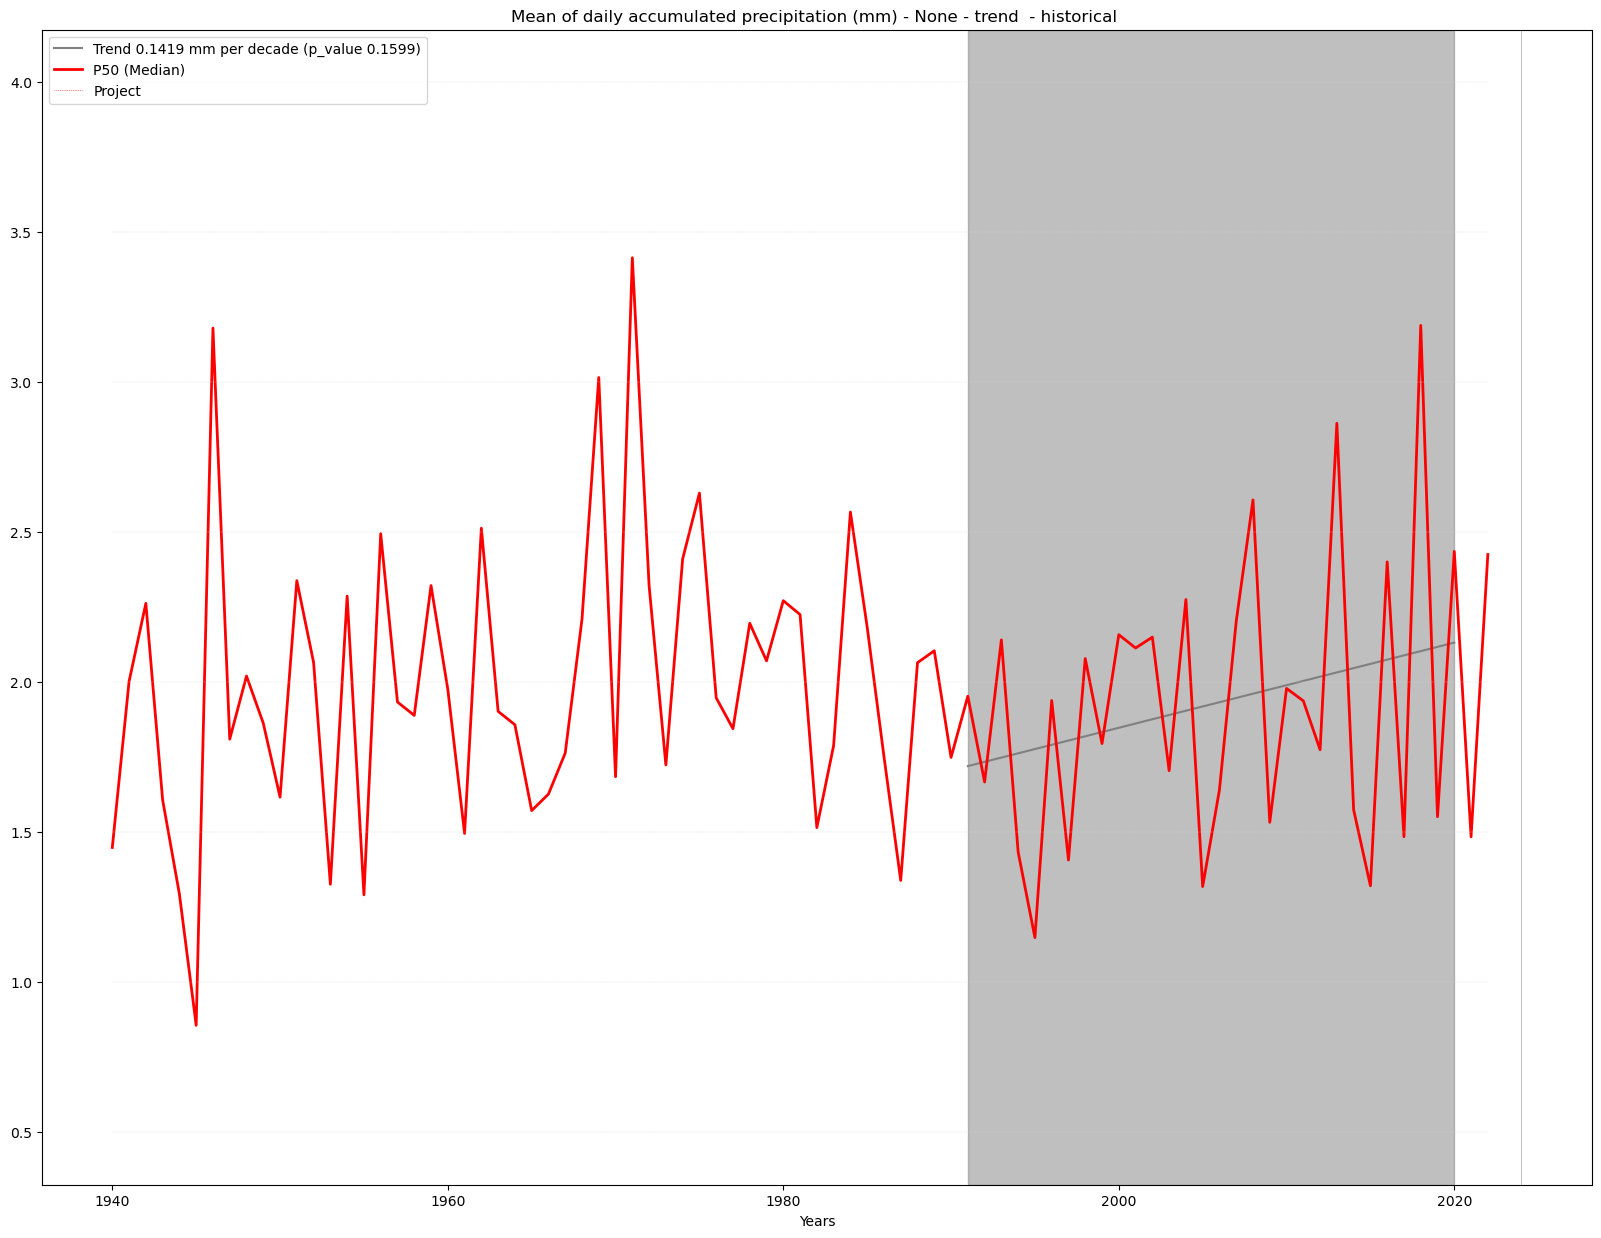

In [43]:
time_series_plot = time_series(time_series_ds, var, attrs, mode = 'trend', 
                               season = season, results = results, 
                               trend_period=trend_period)